# 10. Annex 3: Use the model on a climate dataset

## 10.1 Load CNRM-ESM2 data
CMIP6 climate (earth system model) projections

CNRM-ESM2 - Climate data downloaded from ESGF https://aims2.llnl.gov/metagrid/search/?project=CMIP6

- Sea level pressure [Pa]: psl_day_CNRM-ESM2-1_ssp585_r1i1p1f2_gr_20150101-21001231.nc 
- 500 hPa geopotential height [m]: zg500_AERday_CNRM-ESM2-1_ssp585_r1i1p1f2_gr_20150101-21001231.nc

References: http://www.umr-cnrm.fr/cmip6/references https://explore.es-doc.org/cmip6/further-info?target=CMIP6.CNRM-CERFACS.CNRM-ESM2-1.ssp585.none.r1i1p1f2 

The 256x128 grid points are covering the whole earth for 31411 days (1/1/2015 31/12/2100).

In [1]:
import netCDF4 as nc
for dataset in ["psl","zg500"]:
    df = nc.Dataset("data/ESM2_" + dataset + ".nc",'r')
    print(df.variables.keys())
    print(df[dataset])

dict_keys(['lat', 'lon', 'time', 'time_bounds', 'psl'])
<class 'netCDF4._netCDF4.Variable'>
float32 psl(time, lat, lon)
    long_name: Sea Level Pressure
    units: Pa
    online_operation: average
    cell_methods: area: time: mean
    interval_operation: 900 s
    interval_write: 1 d
    _FillValue: 1e+20
    missing_value: 1e+20
    coordinates: 
    description: Sea Level Pressure
    history: none
    cell_measures: area: areacella
    standard_name: air_pressure_at_mean_sea_level
unlimited dimensions: time
current shape = (31411, 128, 256)
filling on
dict_keys(['lat', 'lon', 'plev', 'time', 'time_bounds', 'zg500'])
<class 'netCDF4._netCDF4.Variable'>
float32 zg500(time, lat, lon)
    online_operation: average
    cell_methods: area: time: mean
    interval_operation: 900 s
    interval_write: 1 d
    _FillValue: 1e+20
    missing_value: 1e+20
    coordinates: plev
    standard_name: geopotential_height
    description: geopotential height on the 500 hPa surface
    long_name: Geo

In [3]:
import numpy as np
zone=np.array([70.,25.,-58.,33.])
for dataset in ["psl","zg500"]:
    df = nc.Dataset("data/ESM2_" + dataset + ".nc",'r')
    data = np.array(df[dataset][:,::-1,:])  # making it N to S
    east = np.array(data[:,int((90-zone[0])*128/180):int((90-zone[1])*128/180),0:int(zone[3]*256/360)])  # 70->25N, 0->33E
    west = np.array(data[:,int((90-zone[0])*128/180):int((90-zone[1])*128/180),int(zone[2]*256/360):])   # 70->25N, 58W->0
    data = np.concatenate((west,east),axis=2)
    print(data.shape)
    np.save("data/climate_" + dataset + ".npy", data)
np.save("data/climate_zone.npy", zone)

(31411, 32, 64)
(31411, 32, 64)


We scale with the same values of the ERA-20C dataset!

In [3]:
msl = np.load("data/climate_psl.npy")
z500 = np.load("data/climate_zg500.npy")
# scale data so that 99,99% is in [0,1]
scale = np.array([[94000,107000],[43000./9.81,58000./9.81]])
msl = (msl - scale[0,0]) / (scale[0,1] - scale[0,0])
z500 = (z500 - scale[1,0]) / (scale[1,1] - scale[1,0])
data = np.zeros((msl.shape[0],msl.shape[1],msl.shape[2],2))
data[:,:,:,0] = msl
data[:,:,:,1] = z500
print(data.shape)
np.save("data/climate.npy", data)
np.save("data/climate_scale.npy", scale)

(31411, 32, 64, 2)


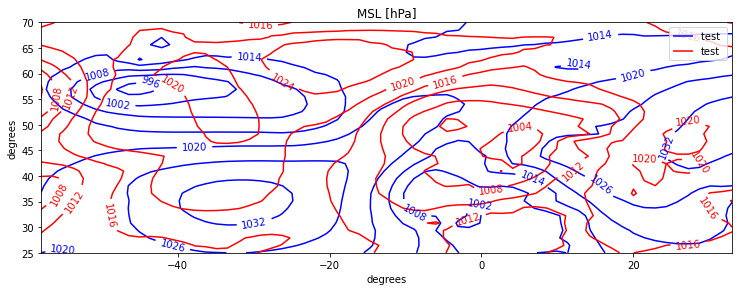

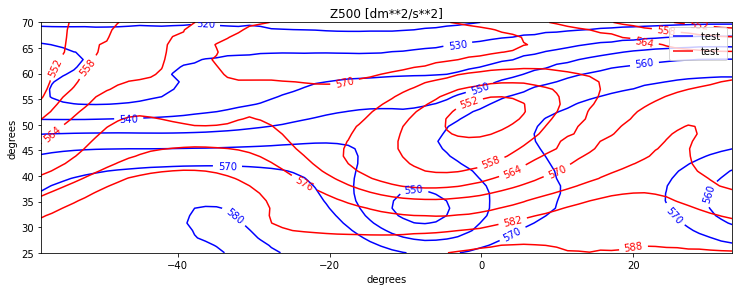

In [5]:
from isoplot import isoplot
isoplot(data[100,:,:,0],data[1000,:,:,0],"test ","test",zone,scale[0])
isoplot(data[100,:,:,1],data[1000,:,:,1],"test ","test",zone,scale[1]*10,"Z500 [dm**2/s**2]")

In [23]:
import datetime
base = datetime.datetime.strptime("01-01-2015", "%d-%m-%Y")
dates = [(base + datetime.timedelta(days=x)).strftime("%Y %-m %-d") for x in range(msl.shape[0])]
np.save("data/climate_dates.npy", dates)
print(len(dates),"days: ",dates[0]," -> ", dates[-1])

31411 days:  2015 1 1  ->  2100 12 31


## 10.2 Does the ERA-20C model also work on the climate dataset?
We load the ERA-20C autoencoder. Does it also work on the climate dataset?

In [18]:
from keras.models import load_model
file="data/climate.npy"
x = np.load(file)
autoencoder = load_model("data/autoencoder.h5")
score = autoencoder.evaluate(x, x, verbose=0)
print('Climate loss:', score)

Test loss: 0.0009813802316784859


Yes it does! Let's use it to compress the climate dataset.

In [19]:
compress = load_model("data/compress.h5")
x_compress = compress.predict(x)
np.save("data/climate_compressed.npy", x_compress)

In [25]:
climate = np.load("data/climate.npy")
compressed = np.load("data/climate_compressed.npy")
dates = np.load("data/climate_dates.npy")
sample_size = 100
grid_points = climate.shape[1] * climate.shape[2]
grid_sqrt = np.sqrt(grid_points) 
rand_indices = np.random.randint(climate.shape[0],size=sample_size)
corr =  np.zeros(sample_size)
corr_msl =  np.zeros(sample_size)
corr_z500 =  np.zeros(sample_size)
for i in range(sample_size):
    date_index = rand_indices[i]
    compressed_ref = compressed[date_index]
    climate_ref = climate[date_index]
    msl_ref = msl[date_index]
    z500_ref = z500[date_index]

    # initialize arrays
    compressed_dist = np.zeros(dates.shape[0])
    msl_dist = np.zeros(dates.shape[0])
    z500_dist = np.zeros(dates.shape[0])
    climate_dist = np.zeros(dates.shape[0])

    # calculate distances
    for j in range(dates.shape[0]):
        compressed_dist[j] = np.linalg.norm(compressed[j]-compressed_ref)
        climate_dist[j] = np.linalg.norm(climate[j]-climate_ref)
        msl_dist[j] = np.linalg.norm(msl[j]-msl_ref) / grid_sqrt
        z500_dist[j] = np.linalg.norm(z500[j]-z500_ref) / grid_sqrt
        
    # calculate correlation coefficients
    corr[i] = np.corrcoef(compressed_dist,climate_dist)[0,1]
    corr_msl[i] = np.corrcoef(compressed_dist,msl_dist)[0,1]
    corr_z500[i] = np.corrcoef(compressed_dist,z500_dist)[0,1]

In [26]:
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
pd_corr = pd.DataFrame(corr, columns=['corr'])
pd_corr['corr_msl'] = pd.DataFrame(corr_msl, columns=['corr'])
pd_corr['corr_z500'] = pd.DataFrame(corr_z500, columns=['corr'])
pd_corr.describe()

,corr,corr_msl,corr_z500
count,100.000,100.000,100.000
mean,0.946,0.523,0.975
std,0.057,0.320,0.022
min,0.715,-0.280,0.854
25%,0.937,0.188,0.968
50%,0.966,0.623,0.983
75%,0.982,0.808,0.990
max,0.990,0.889,0.995


In [27]:
pd_corr.std()/np.sqrt(sample_size) 

corr        0.006
corr_msl    0.032
corr_z500   0.002
dtype: float64

## 10.2 Does the ERA-20C model also work for another zone?
Let's take the US and North Pacific

In [6]:
import numpy as np
zone=np.array([70.,25.,-160.,-70.])
for dataset in ["psl","zg500"]:
    df = nc.Dataset("data/ESM2_" + dataset + ".nc",'r')
    data = np.array(df[dataset][:,::-1,:])  # making it N to S
    data = np.array(data[:,int((90-zone[0])*128/180):int((90-zone[1])*128/180),int(zone[2]*256/360):int(zone[3]*256/360)])   # 70->25N, -160->-70W
    print(data.shape)
    np.save("data/climate_US_" + dataset + ".npy", data)
np.save("data/climate_US_zone.npy", zone)

(31411, 32, 64)
(31411, 32, 64)


In [7]:
msl = np.load("data/climate_US_psl.npy")
z500 = np.load("data/climate_US_zg500.npy")
# scale data so that 99,99% is in [0,1]
scale = np.array([[94000,107000],[43000./9.81,58000./9.81]])
msl = (msl - scale[0,0]) / (scale[0,1] - scale[0,0])
z500 = (z500 - scale[1,0]) / (scale[1,1] - scale[1,0])
data = np.zeros((msl.shape[0],msl.shape[1],msl.shape[2],2))
data[:,:,:,0] = msl
data[:,:,:,1] = z500
print(data.shape)
np.save("data/climate_US.npy", data)
np.save("data/climate_scale.npy", scale)

(31411, 32, 64, 2)


In [32]:
from keras.models import load_model
file="data/climate_US.npy"
x = np.load(file)
autoencoder = load_model("data/autoencoder.h5")
score = autoencoder.evaluate(x, x, verbose=0)
print('Climate US loss:', score)

Climate US loss: 0.0015483705792576075


Not as good as the same zone, but also not that bad!

In [33]:
compress = load_model("data/compress.h5")
x_compress = compress.predict(x)
np.save("data/climate_US_compressed.npy", x_compress)

In [34]:
climate = np.load("data/climate_US.npy")
compressed = np.load("data/climate_US_compressed.npy")
dates = np.load("data/climate_dates.npy")
sample_size = 100
grid_points = climate.shape[1] * climate.shape[2]
grid_sqrt = np.sqrt(grid_points) 
rand_indices = np.random.randint(climate.shape[0],size=sample_size)
corr =  np.zeros(sample_size)
corr_msl =  np.zeros(sample_size)
corr_z500 =  np.zeros(sample_size)
for i in range(sample_size):
    date_index = rand_indices[i]
    compressed_ref = compressed[date_index]
    climate_ref = climate[date_index]
    msl_ref = msl[date_index]
    z500_ref = z500[date_index]

    # initialize arrays
    compressed_dist = np.zeros(dates.shape[0])
    msl_dist = np.zeros(dates.shape[0])
    z500_dist = np.zeros(dates.shape[0])
    climate_dist = np.zeros(dates.shape[0])

    # calculate distances
    for j in range(dates.shape[0]):
        compressed_dist[j] = np.linalg.norm(compressed[j]-compressed_ref)
        climate_dist[j] = np.linalg.norm(climate[j]-climate_ref)
        msl_dist[j] = np.linalg.norm(msl[j]-msl_ref) / grid_sqrt
        z500_dist[j] = np.linalg.norm(z500[j]-z500_ref) / grid_sqrt
        
    # calculate correlation coefficients
    corr[i] = np.corrcoef(compressed_dist,climate_dist)[0,1]
    corr_msl[i] = np.corrcoef(compressed_dist,msl_dist)[0,1]
    corr_z500[i] = np.corrcoef(compressed_dist,z500_dist)[0,1]

In [35]:
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
pd_corr = pd.DataFrame(corr, columns=['corr'])
pd_corr['corr_msl'] = pd.DataFrame(corr_msl, columns=['corr'])
pd_corr['corr_z500'] = pd.DataFrame(corr_z500, columns=['corr'])
pd_corr.describe()

,corr,corr_msl,corr_z500
count,100.000,100.000,100.000
mean,0.950,0.305,0.968
std,0.050,0.366,0.029
min,0.769,-0.463,0.868
25%,0.935,-0.013,0.962
50%,0.971,0.343,0.980
75%,0.986,0.672,0.987
max,0.993,0.775,0.994


In [36]:
pd_corr.std()/np.sqrt(sample_size) 

corr        0.005
corr_msl    0.037
corr_z500   0.003
dtype: float64

The results suggest that it would be possible to build a zone independent compression model.


## 10.3 Investigate multiple zones
We are going to investigate a range of zones shifting west/east for latitude 70->25N and shifting north/south for longitude 58W->33E.


In [30]:
import numpy as np
y_num , x_num = 32 , 64
zone_north, zone_south, zone_west, zone_east = 70, 25, -58, 33
y_north = int((90-zone_north)*128/180) 
y_south = int((90-zone_south)*128/180) 
x_west = int(zone_west*256/360) 
x_east = int(zone_east*256/360) 
for dataset in ["psl","zg500"]:
    df = nc.Dataset("data/ESM2_" + dataset + ".nc",'r')
    world = np.array(df[dataset][:,::-1,:])  # making it N to S
    # west-east
    for x in range(0,256-x_num,16):
        data = np.array(world[:,y_north:y_south,x:x+x_num]) # 70->25N, W/E variable
        print(data.shape)
        zone_west = int(x*360/256)
        np.save("data/range/climate_west_" + str(zone_west) + "_" + dataset + ".npy", data)
    # north-south
    for y in range(0,64-y_num,4): # only N hemisphere
        east = np.array(world[:,y:y+y_num,0:x_east])  # N variable, 0->33E
        west = np.array(world[:,y:y+y_num,x_west:])   # N variable, 58W->0
        data = np.concatenate((west,east),axis=2)
        print(data.shape)
        zone_north = int(y*90/64)
        np.save("data/range/climate_north_" + str(zone_north) + "_" + dataset + ".npy", data)

(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)
(31411, 32, 64)


In [8]:
import numpy as np
y_num , x_num = 32 , 64
scale = np.array([[94000,107000],[43000./9.81,58000./9.81]])
for x in range(0,256-x_num,16):
    zone_west = int(x*360/256)
    msl = np.load("data/range/climate_west_" + str(zone_west) + "_psl.npy")
    z500 = np.load("data/range/climate_west_" + str(zone_west) + "_zg500.npy")
    msl = (msl - scale[0,0]) / (scale[0,1] - scale[0,0])
    z500 = (z500 - scale[1,0]) / (scale[1,1] - scale[1,0])
    data = np.zeros((msl.shape[0],msl.shape[1],msl.shape[2],2))
    data[:,:,:,0] = msl
    data[:,:,:,1] = z500
    print(data.shape)
    np.save("data/range/climate_west_" + str(zone_west) + ".npy", data)
for y in range(0,64-y_num,4): # only N hemisphere
    zone_north = int(y*90/64)
    msl = np.load("data/range/climate_north_" + str(zone_north) + "_psl.npy")
    z500 = np.load("data/range/climate_north_" + str(zone_north) + "_zg500.npy")
    msl = (msl - scale[0,0]) / (scale[0,1] - scale[0,0])
    z500 = (z500 - scale[1,0]) / (scale[1,1] - scale[1,0])
    data = np.zeros((msl.shape[0],msl.shape[1],msl.shape[2],2))
    data[:,:,:,0] = msl
    data[:,:,:,1] = z500
    print(data.shape)
    np.save("data/range/climate_north_" + str(zone_north) + ".npy", data)

(31411, 32, 64, 2)
(31411, 32, 64, 2)
(31411, 32, 64, 2)
(31411, 32, 64, 2)
(31411, 32, 64, 2)
(31411, 32, 64, 2)
(31411, 32, 64, 2)
(31411, 32, 64, 2)
(31411, 32, 64, 2)
(31411, 32, 64, 2)
(31411, 32, 64, 2)
(31411, 32, 64, 2)
(31411, 32, 64, 2)
(31411, 32, 64, 2)
(31411, 32, 64, 2)
(31411, 32, 64, 2)
(31411, 32, 64, 2)
(31411, 32, 64, 2)
(31411, 32, 64, 2)
(31411, 32, 64, 2)


In [9]:
from keras.models import load_model
import numpy as np
y_num , x_num = 32 , 64
autoencoder = load_model("data/autoencoder.h5")
for x in range(0,256-x_num,16):
    zone_west = int(x*360/256)
    x = np.load("data/range/climate_west_" + str(zone_west) + ".npy")
    score = autoencoder.evaluate(x, x, verbose=0)
    print('West', zone_west, ' loss:', score)
for y in range(0,64-y_num,4): # only N hemisphere
    zone_north = int(y*90/64)
    x = np.load("data/range/climate_north_" + str(zone_north) + ".npy")
    score = autoencoder.evaluate(x, x, verbose=0)
    print('North', zone_north, ' loss:', score)

2022-08-08 16:35:09.756838: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


West 0  loss: 0.0019124581012874842
West 22  loss: 0.00242884224280715
West 45  loss: 0.002996147843077779
West 67  loss: 0.0032972171902656555
West 90  loss: 0.0031016876455396414
West 112  loss: 0.002481225412338972
West 135  loss: 0.0017564482986927032
West 157  loss: 0.001384030096232891
West 180  loss: 0.0013517321785911918
West 202  loss: 0.0015630420530214906
West 225  loss: 0.0017605065368115902
West 247  loss: 0.0017428452847525477
North 0  loss: 0.0028983959928154945
North 5  loss: 0.0019376982236281037
North 11  loss: 0.0014039281522855163
North 16  loss: 0.0010739529971033335
North 22  loss: 0.0009535372373647988
North 28  loss: 0.0010369853116571903
North 33  loss: 0.001227789674885571
North 39  loss: 0.0015237935585901141


In [11]:
x = np.load("data/era20c.npy")
score = autoencoder.evaluate(x, x, verbose=0)
print('Era20c loss:', score)

Era20c loss: 0.000801349407993257
